# MNIST with Evidential Deep Learning Uncertainty

This notebook follows the setup used in the paper:

*[Evidential Deep Learning to Quantify Classification Uncertainty](https://proceedings.neurips.cc/paper/2018/file/a981f2b708044d6fb4a71a1463242520-Paper.pdf)*

Please see the paper for mathetmatical details.  Basically we set up a loss function the network learn how uncertain it is about predictions.  We then train on mnist and then evaluate the uncertainty of predictions by manipulating images (rotating them, blending them together) to see if the network learned to be very uncertain about data is has never seen.

In [1]:
import pathlib
import pickle
import sys 
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import torch
from torch import nn 
from torch.nn import functional as F
import torchvision 
import torchvision.transforms.functional as TF
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
import numpy as np

import uncertainty_demo as uncert

SEED = 1371937
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('python version:', sys.version)
print('torch version:', torch.__version__)
print('device:', DEVICE)

python version: 3.9.5 (default, Jun  4 2021, 12:28:51) 
[GCC 7.5.0]
torch version: 1.12.1+cu102
device: cuda


------
# Load the MNIST data set

In [2]:
mnist_train = torchvision.datasets.MNIST("./data/", download=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST("./data/", train=False, download=True, transform=torchvision.transforms.ToTensor())

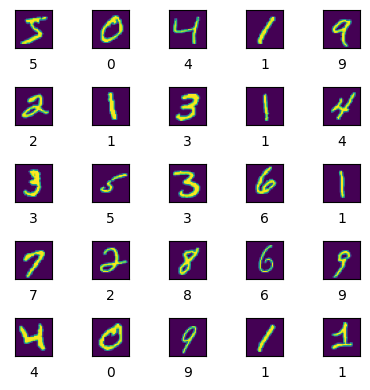

In [3]:
def plot_examples(examples:list, grid=5):
    """Plots a list of images together with their label."""
    fig, axes = plt.subplots(grid,grid, figsize=(4,4))
    for i,ax in enumerate(axes.ravel()):
        ax.imshow(examples[i][0][0])
        ax.set_xlabel(examples[i][1], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.tight_layout()
    fig.set_facecolor('white')
    return fig, ax 

fig,ax = plot_examples([mnist_train[i] for i in range(25)], grid=5)
    
    

-------
# Set up model

We use a simple LeNet CNN to train against the MNIST dataset.

In [4]:
class LeNet(torch.nn.Module):
    r"""LeNet convoluational architecture."""

    def __init__(self, kernel_size=5, d_hidden=500, activation=F.relu, dropout=.3, classifier_activation=None):
        """Initialize a LeNet instance.
        
        Args:
            filter_size: 
            activation:
        """
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=kernel_size)
        self.conv2 = nn.Conv2d(20,50, kernel_size=kernel_size)
        self.max_pool = nn.MaxPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(20000, d_hidden)
        self.fc2 = nn.Linear(d_hidden, 10)
        self.activation=activation
        self.dropout = nn.Dropout(dropout)
        self.classifier_activation = classifier_activation

    def forward(self, x:torch.Tensor):
        """Run a forward pass of the model."""
        x = self.activation(self.max_pool(self.conv1(x)))
        x = self.activation(self.max_pool(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.fc2(x)
        if self.classifier_activation is not None:
            x = self.classifier_activation(x)
        return x

------
# Training code

### Evaluation helpers

We want to evaluate the uncertainy of correct and incorrect predictions.

In [5]:
def uncertainty_accuracy(evidence, target):
    """Calculates the uncertainty of accurate and inaccurate classifications.
    
    Args:
        evidence: evidence tensor of the form :math:`g(model(x))` where 
            :math:`g` is any non-negative transformation.
        target: the true class labels in sparse or one-hot format 
    """
    u = uncert.uncertainty(evidence)
    y_pred = torch.argmax(evidence, -1)
    if target.dim() == 2:
        target = torch.argmax(target, -1) # convert one-hot to sparse
    hit_uncert = torch.mean(torch.tensor([u[i] for i in range(len(evidence)) if y_pred[i]==target[i]]))
    miss_uncert = torch.mean(torch.tensor([u[i] for i in range(len(evidence)) if y_pred[i] != target[i]]))
    return hit_uncert, miss_uncert


In [6]:
def fit_loop(*, model, opt, train_dl,  val_dl=None, epochs=50, reg_steps=10000):
    r"""Runs a model training loop"""
    metrics = defaultdict(list)
    reg_factor = 0.0
    reg_steps_size = 1/reg_steps
    for epoch in range(epochs):
        model.train()
        for i, (x,y) in enumerate(train_dl):
            opt.zero_grad()
            evidence = model(x.to(DEVICE)).cpu()
            loss = uncert.evidential_uncertainty_loss(evidence, y, reg_factor)
            reg_factor += reg_steps_size
            reg_factor = min(reg_factor, 1.0)
            loss.backward()
            opt.step()

            y_pred = torch.argmax(evidence, -1)
            target = y if y.dim()==1 else torch.argmax(y, -1)
            train_hits = y_pred==target
            metrics['train_acc'].append((sum(train_hits)/len(train_hits)).item())
            metrics['train_step'].append(i)
            metrics['train_step_in_epoch'].append(epoch)
            metrics['train_loss'].append(loss.item())

            print(f"Epoch {epoch}: train loss {loss:.3f} reg factor {reg_factor:.3f}", end="\r")

        if val_dl is not None:
            model.eval()
            with torch.no_grad():
                pairs = [(model(x.to(DEVICE)).cpu(),y) for x,y in val_dl]
                val_loss = torch.nanmean(torch.tensor([uncert.evidential_uncertainty_loss(x,y,reg_factor) for x,y in pairs]))
                # measure accuracy
                y_pred = torch.stack([torch.argmax(p[0],-1) for p in pairs], 0).reshape(-1)
                if pairs[0][1].dim()==2:
                    target = torch.tensor([torch.argmax(p[1]) for p in pairs])
                else:
                    target = torch.stack([p[1] for p in pairs], 0).reshape(-1)
                hits = y_pred==target 

                val_acc = sum(hits)/len(hits)
                metrics['val_accuracy'].append(val_acc)

                # meausre a bunch of other stuff
                u_acc = [uncertainty_accuracy(x, y) for x,y in pairs]
                hit_uncert = torch.nanmean(torch.tensor([u[0] for u in u_acc]))
                miss_uncert = torch.nanmean(torch.tensor([u[1] for u in u_acc]))
                metrics['val_loss'].append(val_loss.item())
                metrics['hit_uncertainty'].append(hit_uncert)
                metrics['miss_uncertainty'].append(miss_uncert)
                metrics['epoch'].append(epoch)
                metrics['val_step'].append(i)

        if epoch %10 == 0:        
            print(f'\nEpoch {epoch}: train loss {loss:.3f} val_acc: {val_acc:.3f} val_loss {val_loss:.3f} hit u {hit_uncert:.3f} miss u {miss_uncert:.3f}')
    return metrics

### Train models
We train a model with each type of evidence: relu, exp, softplus.  

From reading the [paper's original notebook](https://muratsensoy.github.io/uncertainty.html) they suggest `exp` evidence works the best.  However, in the notebook the rotating image classifier with the "cleanest" curve is the one trained with `relu` evidence.  We train all 3 at once so we can experiment with them later. 

In [7]:
e_funcs = [uncert.exp_evidence, uncert.relu_evidence, uncert.softplus_evidence]
e_names = ['exp', 'relu', 'softplus']
train_dl = torch.utils.data.DataLoader(mnist_train, batch_size=1000, num_workers=8)
val_dl = torch.utils.data.DataLoader(mnist_test, batch_size=32, drop_last=True)
reg_steps = 10*len(train_dl) # saturate after 10 epochs
metrics = {}
models = {}

model_path = pathlib.Path('./artifacts/models')
model_path.mkdir(parents=True, exist_ok=True)
metric_path = model_path / 'training_metrics'
metric_path.mkdir(parents=True, exist_ok=True)

for evidence_func, name in zip(e_funcs, e_names):
    torch.manual_seed(SEED)
    model_file = model_path / f'mnist_evidential_{name}.pt'
    metrics_file = metric_path / f'mnist_evidential_{name}.pkl'
    if model_file.exists() and metrics_file.exists():
        state_dict = torch.load(model_file)
        _model = LeNet()
        _model.load_state_dict(state_dict)
        _model.to(DEVICE)
        with open(metrics_file, 'r') as f:
            _metrics = pickle.load(f)
        models[name]= _model 
        metrics[name] = _metrics
    else:
        _model = LeNet(classifier_activation=evidence_func).to(DEVICE)
        _metrics = fit_loop(model=_model, opt=torch.optim.AdamW(_model.parameters(), lr=1e-3), train_dl=train_dl, val_dl=val_dl, reg_steps=reg_steps)

        torch.save(_model.state_dict(), model_file)
        with open(metrics_file, 'wb') as f:
            pickle.dump(_metrics, f)
        models[name] = _model 
        metrics[name] = _metrics 


Epoch 0: train loss 0.077 reg factor 0.100
Epoch 0: train loss 0.077 val_acc: 0.969 val_loss 0.091 hit u 0.057 miss u 0.530
Epoch 10: train loss 0.021 reg factor 1.000
Epoch 10: train loss 0.021 val_acc: 0.990 val_loss 0.091 hit u 0.026 miss u 0.668
Epoch 20: train loss 0.017 reg factor 1.000
Epoch 20: train loss 0.017 val_acc: 0.991 val_loss 0.082 hit u 0.025 miss u 0.704
Epoch 30: train loss 0.009 reg factor 1.000
Epoch 30: train loss 0.009 val_acc: 0.992 val_loss 0.106 hit u 0.018 miss u 0.620
Epoch 40: train loss 0.074 reg factor 1.000
Epoch 40: train loss 0.074 val_acc: 0.991 val_loss 0.091 hit u 0.018 miss u 0.649
Epoch 0: train loss 0.158 reg factor 0.1000
Epoch 0: train loss 0.158 val_acc: 0.919 val_loss 0.195 hit u 0.219 miss u 0.681
Epoch 10: train loss 0.066 reg factor 1.000
Epoch 10: train loss 0.066 val_acc: 0.970 val_loss 0.084 hit u 0.114 miss u 0.938
Epoch 20: train loss 0.050 reg factor 1.000
Epoch 20: train loss 0.050 val_acc: 0.971 val_loss 0.078 hit u 0.087 miss u 0

-------
# Evaluate the model

We now look at some of the metrics during training.

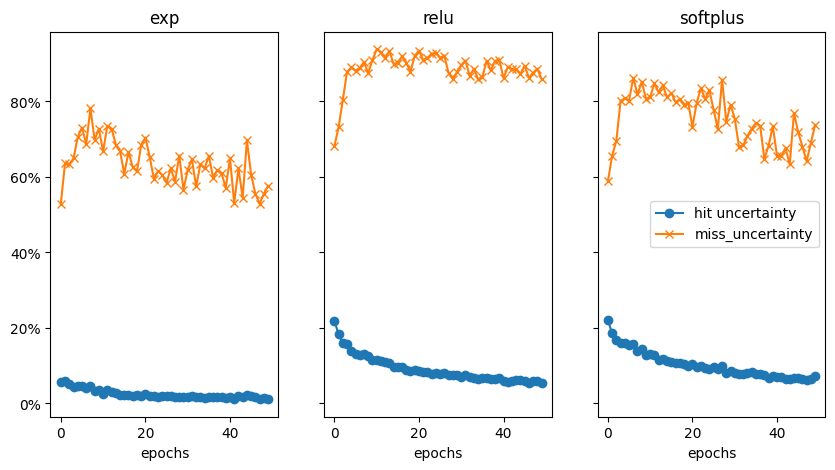

In [8]:
def plot_validation_metrics(metrics, ax=None):
    """Plots the uncertainty and accuracy metrics."""
    import matplotlib.ticker as mtick
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(metrics['epoch'], metrics['hit_uncertainty'], '-o', label='hit uncertainty')
    ax.plot(metrics['epoch'], metrics['miss_uncertainty'], '-x', label='miss_uncertainty')
    ax.set_xlabel('epochs')
    ax.set_title('Validation Uncertainty')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    return ax 

fig, ax = plt.subplots(1,3, figsize=(10,5), sharey=True)
for i, (name, m) in enumerate(metrics.items()):
    plot_validation_metrics(m, ax=ax[i])
    ax[i].set_title(name)
plt.legend();

These plots show that the uncertainty for examples that the model got correct is much lower than the uncertainty for examples it gets incorrect.  That is what we anticipated.

It seems the exponential evidence has the lowest uncertainty for hits, the relu has the highest uncertainty for misses, and the softplus is kinda of the worst of both worlds.

In [9]:
def get_validation_results(model, ds):
    """Computes predictions and uncertainty for each example in the dataset."""
    model.eval()
    image = []
    label = []
    prediction = [] 
    uncert_ = []
    device = next(model.parameters()).device
    with torch.no_grad():
        for x,y in ds:
            image.append(x.numpy())
            label.append(y)
            _evidence = model(x.unsqueeze(0).to(device)).cpu()
            _pred = torch.argmax(_evidence, -1).item()
            prediction.append(_pred)
            uncert_.append(uncert.uncertainty(_evidence).item())
    return image, label, prediction, uncert_


result = {}
for name, m in models.items():
    result[name] = get_validation_results(m, mnist_test)



### Look at some examples with high uncertainty

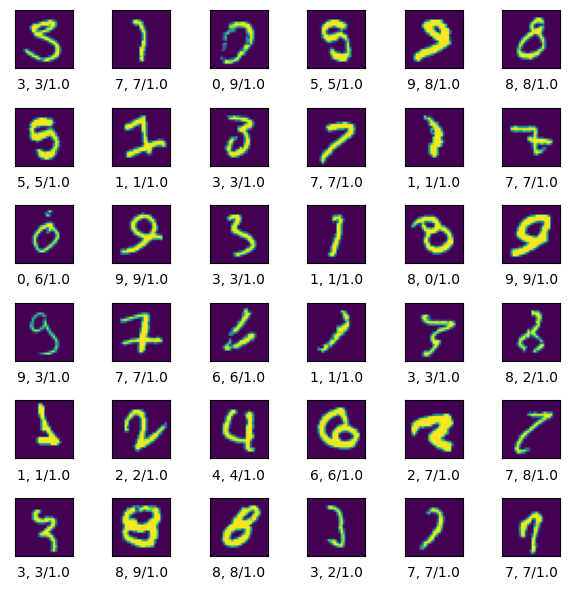

In [10]:
def sort_by_uncertainty(r, reverse=False):
    """Sorts the results by uncertainty.
    
    Probably a smarter way to do this, but it works for now.
    """
    r = sorted([t for t in zip(*r)], key=lambda x: x[-1], reverse=reverse)
    return tuple(zip(*r))


def plot_uncertain_examples(images, labels, predictions, uncertainty, grid=3):
    """Plots images some meta data"""
    fig, axes = plt.subplots(grid, grid, figsize=(6,6))
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(images[i][0])
        ax.set_xlabel(f"{labels[i]}, {predictions[i]}/{uncertainty[i]:.1f}")
        ax.set_xticks([])
        ax.set_yticks([])
    fig.tight_layout()
    return fig, ax    

def select_n(result, n):
    """Selects the first n examples from the results."""
    return tuple([r[:n] for r in result])


result = {name: sort_by_uncertainty(r, reverse=True) for name, r in result.items()}
fig,ax = plot_uncertain_examples(*select_n(result['exp'],36), grid=6)

Many of these examples are "difficult" for example the 5 in the last row.  It is also interesting to see that some extra "ink" in the 1 and 0 in the second row cause the model to become less certain even when the image itself is very clear that its a one.  Not that we care for mnist, but this type of analysis would lead us to conlude that "random ink" could be a good augmentation strategy.  This is an example of the type of thing we might do with uncertainty.




#### Filter by uncertainty scores
We can simulate what would happen if we flagged elements with high uncertainty for human review.  In other words, we score each example for uncertainty and then we filter out those above a certain threshold and measure the accuracy on the ones we are certain about.

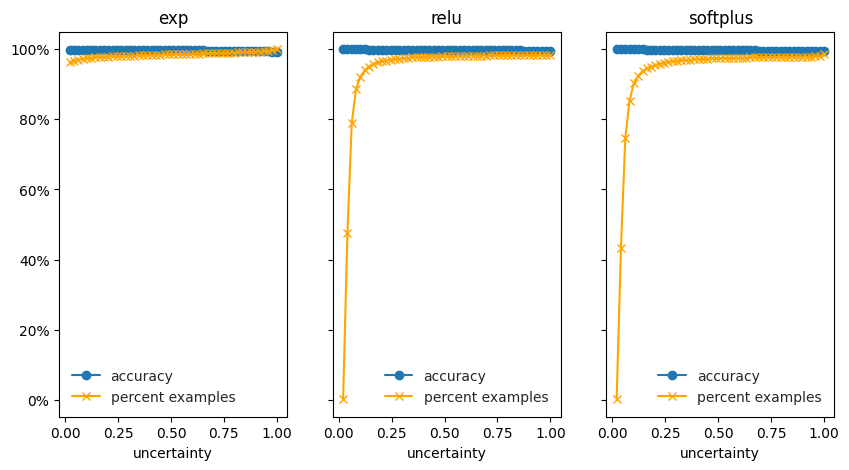

In [11]:
def plot_acc_vs_uncertainty(result, u_range=None, ax=None):
    images, targets, pred, uncert_ = sort_by_uncertainty(result)
    hits = np.array(targets) == np.array(pred)
    acc = []
    uncert_vals = []
    bars = []
    u_range = np.linspace(0,1,50) if u_range is None else u_range
    for u in u_range:
        u_index = np.searchsorted(uncert_, u)
        if len(hits[:u_index])>0:
            acc.append(sum(hits[:u_index])/len(hits[:u_index]))
            uncert_vals.append(u)
            bars.append(len(hits[:u_index])/len(hits))
    plt.style.use('seaborn-whitegrid')
    if ax is None:
        fig,ax = plt.subplots(figsize=(4,4))
    ax.plot(uncert_vals, acc, '-o', label='accuracy')
    ax.plot(uncert_vals, bars, '-x', color='orange', label='percent examples')
    ax.legend()
    ax.set_xlabel('uncertainty')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


fig,ax = plt.subplots(1,3, figsize=(10,5), sharey=True)
for i,name in enumerate(result):
    plot_acc_vs_uncertainty(result[name], ax=ax[i])
    ax[i].set_title(name);


This is actually a bit hard to interpret.  In the case where the uncertainty threshold is very very low, its clear that exp is doing the best (the most samples are making through the threshold with high accuracy).  Let's compare them directly.

We compare them by looking over a range of uncertainty thresholds.  For each threshold we score the examples that fall below that threshold, and the remaining are "sent for review".  Then to compare we ask "for a fixed number of examples going to review (say 5%) what is the accuracy of the model on the remaining examples (95%)".  This lets us compare model accuracy against an absolute number which measure the degree to which we can automate the model vs how much we need a human in the loop to achieve high accuracy

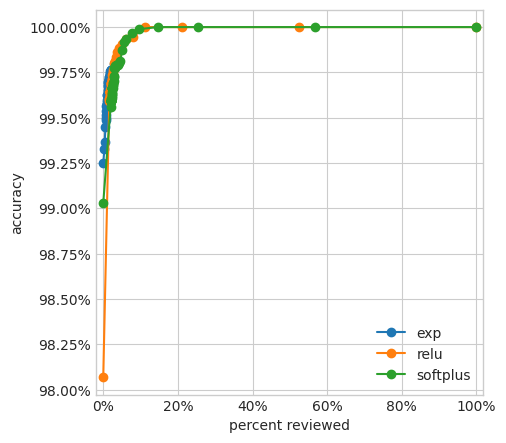

In [12]:
def compare_results(*args,labels=None, u_range=None, ax=None):
    labels = [None]*len(args) if labels is None else labels
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
    
    max_review = -1
    min_review = 10000
    u_range = np.linspace(0,1,50) if u_range is None else u_range
    for i, result in enumerate(args):    
        images, targets, pred, uncert_ = sort_by_uncertainty(result)
        hits = np.array(targets) == np.array(pred)
        acc = []
        uncert_vals = []
        percent_review = []

        for u in u_range:
            u_index = np.searchsorted(uncert_, u,side='right')
            if len(hits[:u_index])>0:
                acc.append(sum(hits[:u_index])/len(hits[:u_index]))
                uncert_vals.append(u)
                percent_review.append(1-(len(hits[:u_index])/len(hits)))
        plt.style.use('seaborn-whitegrid')
        ax.plot(percent_review, acc, '-o', label=labels[i])
        #plt.plot(uncert_vals, bars, '-x', color='orange', label='percent examples')
        plt.legend()
        ax.set_xlabel('percent reviewed')
        ax.set_ylabel('accuracy')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        max_review = max(max_review, max(percent_review))
        min_review = min(min_review, min(percent_review))
    ax.set_xlim([min_review-.02, max_review+.02])

compare_results(*result.values(), labels=list(result.keys()))

This is also hard to interpret so we will zoom in below, but one interesting thing we can learn from this is that if we need 100% accuracy and are willing to review a high percentage of examples (20%) then we have to use `relu` or `softplus`.

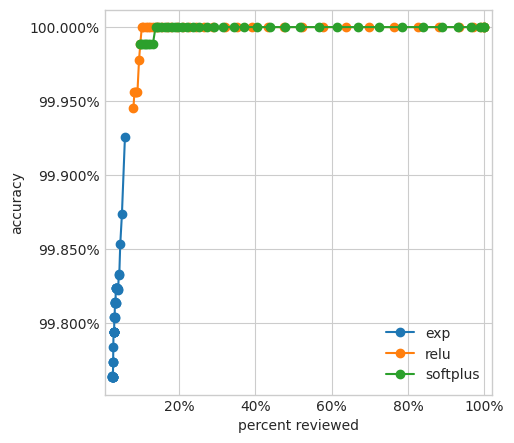

In [13]:
compare_results(*result.values(), labels=list(result.keys()), u_range=np.linspace(0,.1,50))

This plot shows the examples whose uncertainty scores is less than or equal to 0.1, the "highly certain examples".  We can see that exponential evidence has more highly certain examples (smaller percent reviewed) but that the accuracy of these examples is only so high.  If we were willing or needing to achieve high accuracy, at the cost of more review, we would need to use relu or softplus, both able to achieve 100% accuracy, softplus doing so with ~17% review, meaning the model can achieve 100% accuracy on the 83% it is most confident about, leaving the remaining 17% for human review.

The choice of activation will likely be depending on the application.  If we need more automation, then `exp` seems like a good choice since it achieves the highest out of the box accuracy and can achieve even higher accuracy with a small percentage sent to review.  If we need extremely high accuracy and are willing to sacrifice automation then `softplus` or `relu` seem like better choices since they can achieve 100% accuracy at the cost of more review.

### Image Manipulation

We now see how well these methods work for OOD samples.  We can create fake OOD samples by rotating images.  The model was not trained with any data augmentation so has never seen a "sideways 2".  The uncertainty for these rotated images should be high. 

In [14]:
def plot_uncertainty_rotated(model, image, ax=None):
    """Plots the uncertainty for a given image over a range of rotations."""
    if ax is None:
        fig,ax = plt.subplots(1,1, figsize=(5,5))
    device = next(model.parameters()).device
    image = image.to(device)
    uncert_ = []
    angles = np.linspace(0,180,25)
    for a in angles:
        rotated = TF.rotate(image, a)
        evidence = model(rotated.unsqueeze(0)).cpu()
        uncert_.append(uncert.uncertainty(evidence).item())
    ax.plot(angles, uncert_, '-o')
    ax.set_xlabel('rotation (degrees)')
    ax.set_ylabel('uncertainty')
    
def get_digits(ds, digit):
    """Gets all examples of a given digit from the dataset."""
    return [x for x,y in ds if y==digit]


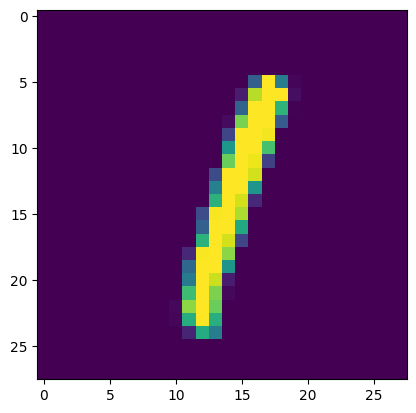

In [15]:
ones = get_digits(mnist_test, 1)
one_example = ones[1]
plt.style.use('default')
plt.imshow(one_example[0])

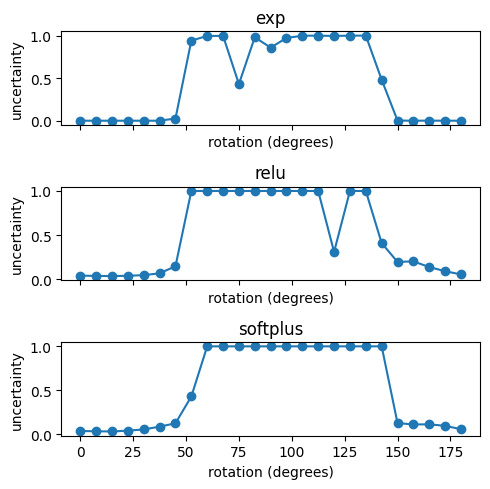

In [16]:
fig, ax = plt.subplots(3,1, figsize=(5,5), sharex=True)
for i, (name,model) in enumerate(models.items()):
    plot_uncertainty_rotated(models[name], one_example, ax=ax[i])
    ax[i].set_title(name)
    fig.tight_layout()

UPDATE: After re-running this a few times (retraining) it seems like generally the softplus and relu are the most confident and exp tends to "make more mistakes" when rotating.  It's not clear that there is a winner here - but generally speaking it seems like `exp` evidence is more accurate but `relu` and `softplus` seem to be better at quantifying uncertainty.

Note to self: What would happen if we chose a hybrid evidence function, e.g. the average of the three?

##### Try another example

The example below is particularly confusing for the models when rotated. 

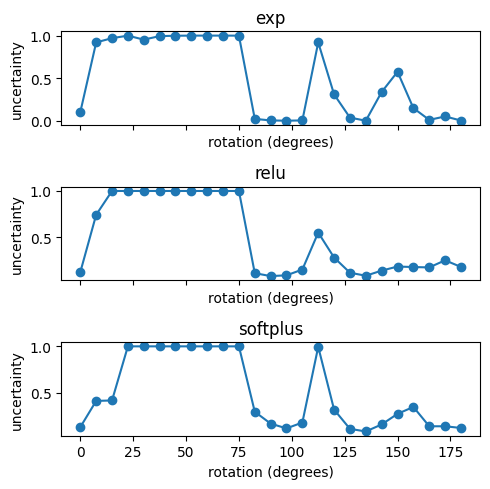

In [17]:
fig, ax = plt.subplots(3,1, figsize=(5,5), sharex=True)
for i, (name,model) in enumerate(models.items()):
    plot_uncertainty_rotated(models[name], ones[13], ax=ax[i])
    ax[i].set_title(name)
    fig.tight_layout()

predicted class: 5


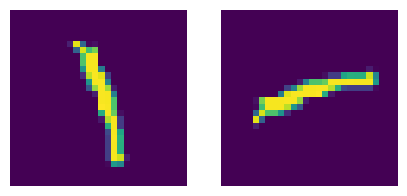

In [18]:
fig,ax = plt.subplots(1,2, figsize=(5,3))
ax[0].imshow(ones[13][0])
rot_img = TF.rotate(ones[13], 90)
ax[1].imshow(rot_img[0])
_evidence = models['relu'](rot_img.unsqueeze(0).to(DEVICE)).cpu()
print(f"predicted class: {torch.argmax(_evidence)}")
for a in ax:
    a.axis('off')


For whatever reason, this particular `1` looks like a `5` to the model when its rotated this way and the model is more certain about that compared to other examples of `1`s.  I'm not sure why, but it does show that this uncertainty loss is not 100% robust to OOD.

It would be interesting to compare the results here to the setup in the paper: [Information Aware Max-Norm Dirichlet Networks for
Predictive Uncertainty Estimation](https://arxiv.org/pdf/1910.04819.pdf)
which builds on the idea of using dirichlet distributions to model uncertainty but whose math I have not fully gone through enough to implement.


-------
# Compare with softmax

It is reasonable to wonder if we could get the same effect by using traditional neural network training without uncertainty - instead can we just filter by model "probabilities"?  To answer this question we train another neural network with traditional cross entropy loss.  We then measure uncertainty as `1-max(softmax(logits))` which is basically the amount of probability not accounted for by the most likely class. If the model predicts digit 2 with 99% probability then the uncertainty is 1%.

In [19]:
def softmax_accuracy(logits, target):
    p = F.softmax(logits, -1)
    y_pred = torch.argmax(logits, -1)
    if target.dim() == 2:
        target = torch.argmax(target, -1) # convert one-hot to sparse
    hit_proba = torch.mean(torch.tensor([torch.max(p[i]) for i in range(len(p)) if y_pred[i]==target[i]]))
    miss_proba = torch.mean(torch.tensor([torch.max(p[i]) for i in range(len(p)) if y_pred[i] != target[i]]))
    return hit_proba, miss_proba




def cross_entropy_fit_loop(*, model, train_dl, val_dl, opt, epochs=50):
    metrics = defaultdict(list)
    for epoch in range(epochs):
        model.train()
        for i, (x,y) in enumerate(train_dl):
            opt.zero_grad()
            logits = model(x.to(DEVICE)).cpu()
            loss = F.cross_entropy(logits, y)
            loss.backward()
            opt.step()

            y_pred = torch.argmax(logits, -1)
            target = y if y.dim()==1 else torch.argmax(y, -1)
            train_hits = y_pred==target
            metrics['train_acc'].append((sum(train_hits)/len(train_hits)).item())
            metrics['train_step'].append(i)
            metrics['train_step_in_epoch'].append(epoch)
            metrics['train_loss'].append(loss.item())

            print(f"Epoch {epoch}: train loss {loss:.3f}", end="\r")

        if val_dl is not None:
            model.eval()
            with torch.no_grad():
                pairs = [(model(x.to(DEVICE)).cpu(),y) for x,y in val_dl]
            val_loss = torch.nanmean(torch.tensor([F.cross_entropy(x,y) for x,y in pairs]))
            
            # measure accuracy
            y_pred = torch.stack([torch.argmax(p[0],-1) for p in pairs], 0).reshape(-1)
            if pairs[0][1].dim()==2:
                target = torch.tensor([torch.argmax(p[1]) for p in pairs])
            else:
                target = torch.stack([p[1] for p in pairs], 0).reshape(-1)
            hits = y_pred==target 

            val_acc = sum(hits)/len(hits)
            metrics['val_accuracy'].append(val_acc)

            # meausre a bunch of other stuff
            metrics['val_loss'].append(val_loss.item())
            metrics['epoch'].append(epoch)
            metrics['val_step'].append(i)
            s_acc = [softmax_accuracy(x, y) for x,y in pairs]
            # naively say uncertainty is 1-proba
            hit_uncert = 1 - torch.nanmean(torch.tensor([s[0] for s in s_acc]))
            miss_uncert = 1 - torch.nanmean(torch.tensor([s[1] for s in s_acc]))
            metrics['hit_uncertainty'].append(hit_uncert)
            metrics['miss_uncertainty'].append(miss_uncert)
            

    
            print(f'\nEpoch {epoch}: train loss {loss:.3f} val_acc: {val_acc:.3f} val_loss {val_loss:.3f} hit u {hit_uncert:.3f} miss u {miss_uncert:.3f}')
    return metrics

In [20]:
model_file = model_path / 'mnist_cross_entropy.pt'
metrics_file = model_path / 'training_metrics' / 'mnist_cross_entropy.pkl'


if model_file.exists() and metrics_file.exists():
    state_dict = torch.load(model_file)
    model_ce = LeNet()
    model_ce.load_state_dict(state_dict)
    with open(metrics_file, 'rb') as f:
        metrics_ce = pickle.load(f)
else:
    torch.manual_seed(SEED)
    model_ce = LeNet(classifier_activation=None)
    model_ce.to(DEVICE)
    metrics_ce = cross_entropy_fit_loop(
        model=model_ce, 
        train_dl=train_dl, 
        val_dl=val_dl, 
        opt=torch.optim.AdamW(model_ce.parameters(), lr=1e-3, weight_decay=5e-3),
        epochs=50)
    torch.save(model_ce.state_dict(), model_file)
    with open(metrics_file, 'wb') as f:
        pickle.dump(metrics_ce, f)

Epoch 0: train loss 0.109
Epoch 0: train loss 0.109 val_acc: 0.974 val_loss 0.090 hit u 0.028 miss u 0.309
Epoch 1: train loss 0.069
Epoch 1: train loss 0.069 val_acc: 0.984 val_loss 0.051 hit u 0.015 miss u 0.284
Epoch 2: train loss 0.053
Epoch 2: train loss 0.053 val_acc: 0.988 val_loss 0.039 hit u 0.011 miss u 0.264
Epoch 3: train loss 0.036
Epoch 3: train loss 0.036 val_acc: 0.987 val_loss 0.039 hit u 0.008 miss u 0.255
Epoch 4: train loss 0.033
Epoch 4: train loss 0.033 val_acc: 0.987 val_loss 0.041 hit u 0.009 miss u 0.255
Epoch 5: train loss 0.033
Epoch 5: train loss 0.033 val_acc: 0.990 val_loss 0.033 hit u 0.008 miss u 0.252
Epoch 6: train loss 0.021
Epoch 6: train loss 0.021 val_acc: 0.990 val_loss 0.028 hit u 0.005 miss u 0.236
Epoch 7: train loss 0.018
Epoch 7: train loss 0.018 val_acc: 0.991 val_loss 0.029 hit u 0.005 miss u 0.243
Epoch 8: train loss 0.016
Epoch 8: train loss 0.016 val_acc: 0.990 val_loss 0.032 hit u 0.005 miss u 0.226
Epoch 9: train loss 0.015
Epoch 9: tr

### Check Crossentropy uncertainty

<AxesSubplot: title={'center': 'Validation Uncertainty'}, xlabel='epochs'>

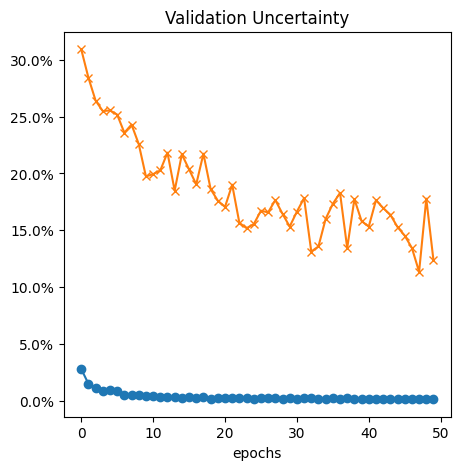

In [21]:
plot_validation_metrics(metrics_ce)

So the uncertainty for correct answers is much lower than that for incorrect answers, but looking at the previous plot from the model trained with dirichlet uncertainty loss, we can see this gap is much smaller and is getting smaller over training epochs, not larger

In [22]:
def get_validation_results_ce(model, ds):
    """Computes predictions and uncertainty for each example in the dataset."""
    model.eval()
    image = []
    label = []
    prediction = [] 
    uncert_ = []
    device = next(model.parameters()).device
    with torch.no_grad():
        for x,y in ds:
            image.append(x.numpy())
            label.append(y)
            _logits = model(x.unsqueeze(0).to(device)).cpu()
            _pred = torch.argmax(_logits, -1).item()
            prediction.append(_pred)
            uncert_.append(1-torch.max(F.softmax(_logits,-1)).item())
    return image, label, prediction, uncert_

(<Figure size 600x600 with 36 Axes>, <AxesSubplot: xlabel='4, 9/0.3'>)

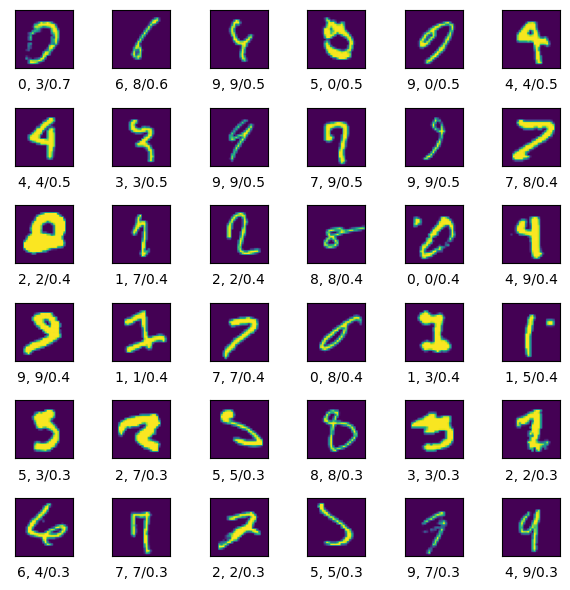

In [23]:
result_ce = get_validation_results_ce(model_ce, mnist_test)
result_ce = sort_by_uncertainty(result_ce, reverse=True)
plt.style.use('default')
plot_uncertain_examples(*select_n(result_ce, 36), grid=6)


There is some overlap here and some differences with the examples found the the other uncertainty models.  Note that the uncertainty score maxes out at 0.6.


### Plot Accuracy vs Uncertainty

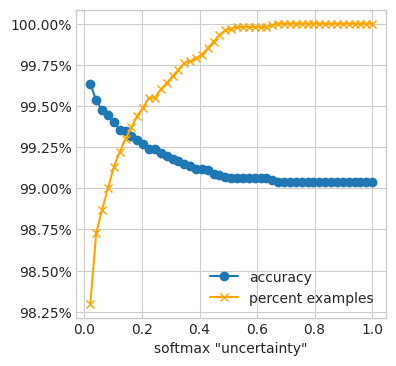

In [24]:
plot_acc_vs_uncertainty(result_ce)
plt.xlabel('softmax "uncertainty"');

So it looks like we can get up to 99.6% accuracy on all but the 1.4% of hardest examples using softmax uncertainty.  Let's see how this compares.

## Compare Uncertainty vs Softmax Cross Entropy
The plots are very hard to compare visually.  Let's plot them together so we can see which is more accurate.  We do this by holding out the top X% most uncertain examples that we would send for "human review".  The remaining 100-X% examples are sent to the model to be scored and the accuracy metrics is plotted.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


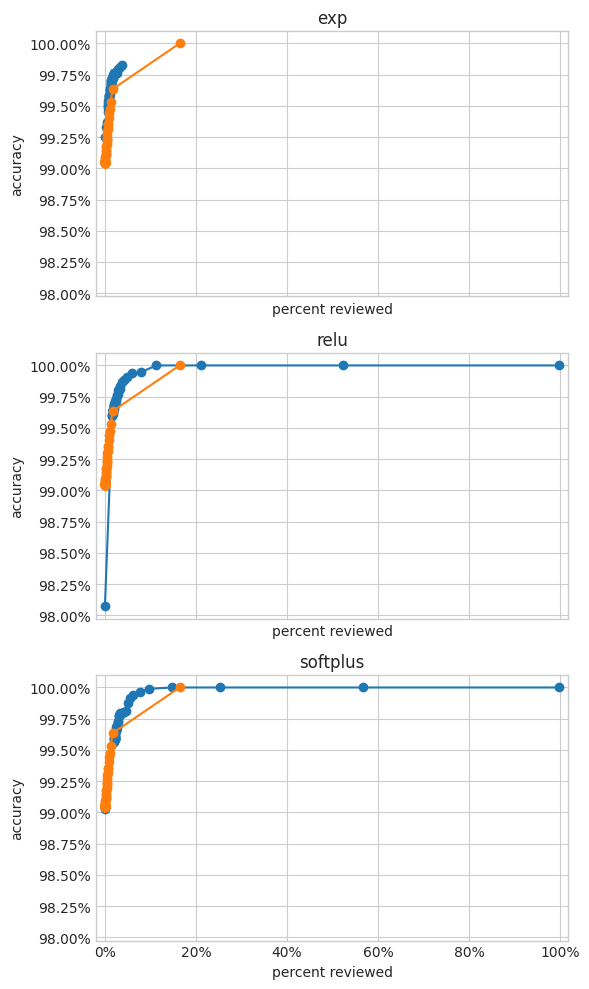

In [25]:
fig, ax = plt.subplots(3,1, figsize=(6,10), sharey=True, sharex=True)

compare = [result['softplus'], result_ce]
compare = [result['exp'], result['relu']]

for i,(name, r) in enumerate(result.items()):
    compare_results(r, result_ce, labels=None, ax=ax[i])
    ax[i].set_title(name)
fig.tight_layout()

It's clear that when we need more accuracy with more review, all the uncertainty methods are better.  Let's also zoom in on the portion of "small amount of review"

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


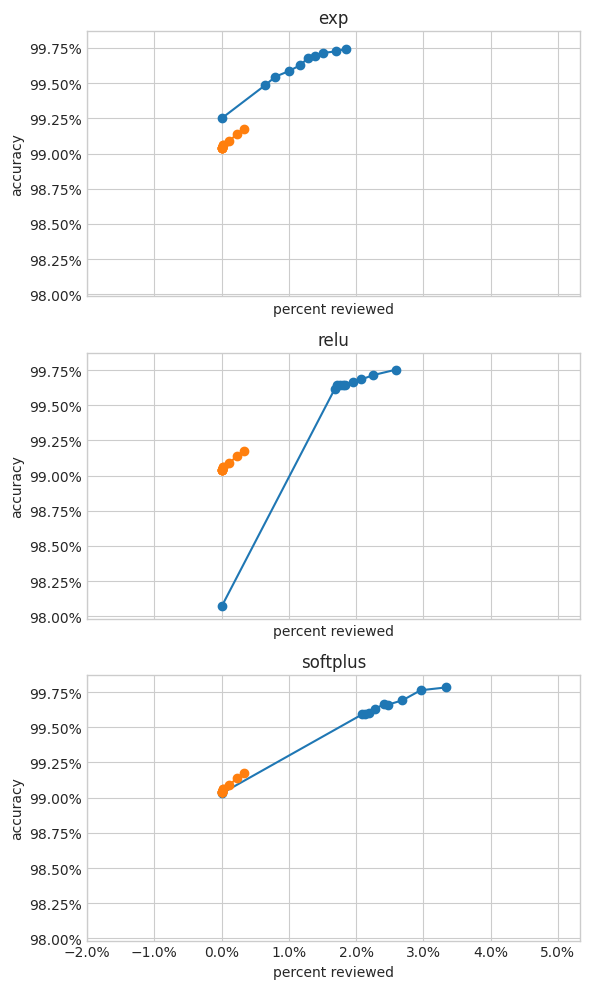

In [26]:
fig, ax = plt.subplots(3,1, figsize=(6,10), sharey=True, sharex=True)

compare = [result['softplus'], result_ce]
compare = [result['exp'], result['relu']]

for i,(name, r) in enumerate(result.items()):
    compare_results(r, result_ce, labels=None, ax=ax[i], u_range=np.linspace(.3,1,10))
    ax[i].set_title(name)
fig.tight_layout()

Again, the exponential evidence is the best right out of the box without filtering.  The relu network doesn't shine until we get up to review about 1.5% and is about equivalent to `exp` in that range.  The softplus is better than softmax out of the box but not quite as good as relu or exp for very small amounts of review (even though we know its much better when we allow more of review, shooting up to 100% accuracy).

## Crossentropy Image Rotation

We have seen that the uncertain loss offers a better trade-off of accuracy and "automation" when filtering examples by sending highly uncertain examples for human review, compared to a model trained with traditional softmax cross entropy.  One could reasonably argue that this is due to randomness - the uncertainty model happened to do better in this particular case, with this particular initialization, etc.


Let's also check that when we rotate images, we get better results from the uncertainty models than we do from the crossentropy model.

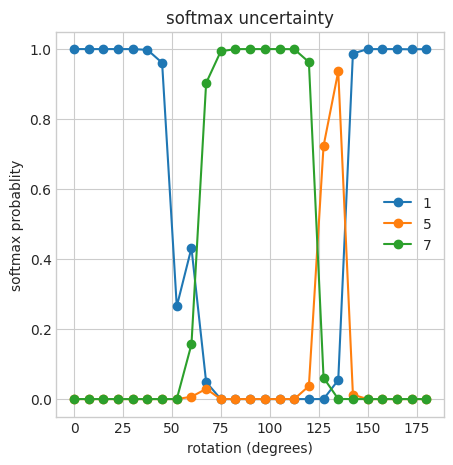

In [27]:
def plot_uncertainty_rotated_ce(model, image, ax=None, classes=None):
    """Plots the uncertainty for a given image over a range of rotations."""
    if ax is None:
        fig,ax = plt.subplots(1,1, figsize=(5,5))
    device = next(model.parameters()).device
    image = image.to(device)
    uncert_ = []
    probas = defaultdict(list)
    angles = np.linspace(0,180,25)
    for a in angles:
        rotated = TF.rotate(image, a)
        _logits = model(rotated.unsqueeze(0)).cpu()
        _p = F.softmax(_logits,-1)
        if classes is not None:
            for c in classes:
                probas[c].append(_p[0,c].detach().numpy())
            
        uncert_.append(1-torch.max(_p).item())


    if classes is not None:
        for c,p in probas.items():
            ax.plot(angles, p, '-o', label=c)
        ax.set_ylabel('softmax probablity')
    else:
        ax.plot(angles, uncert_, '-o', label='uncertainty')
        ax.set_ylabel('uncertainty')
    ax.set_xlabel('rotation (degrees)')


plot_uncertainty_rotated_ce(model_ce, one_example, classes=[1,5,7])
plt.title('softmax uncertainty')
plt.legend()

For this example the model is sure its a 1, then it thinks its a 1 or a 5 (with a slight preference for 5) and finally it is very sure its a 7, before rotating back to being sure its a 1.  We can see that the softmax probabilities are far too optimistic, with probabilities of 100% certain the rotated 1 is a 7.  In contrast, the plots above shows that we can detect these OOD rotations by using uncertainty loss.

See below for a direct comparison to the plots above.

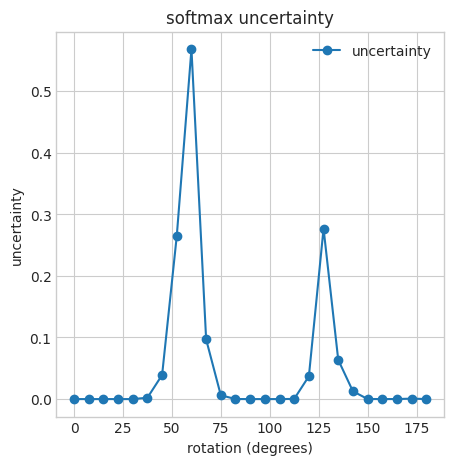

In [28]:
plot_uncertainty_rotated_ce(model_ce, one_example)
plt.title('softmax uncertainty')
plt.legend()

This is a another view of the above plot and compares to the uncertainty plots for rotation above.  It shows the model is highly certain (0 uncertainty) for many of the rotations, even though it should be more uncertain since its never seen a rotated 1 during training.

------------
# Conclusion
In this notebook we trained several models with uncertainty loss and with traditional cross entropy loss.  We built more intuition for how well uncertainty works, at least on a toy dataset, and saved these models for future use. 

The next steps are 

1. Build an interactive web app for highlighting uncertainty, starting with mnist and widgets for rotation and other augmentations.
2. Look for a more realistic dataset, ideally with high impact, e.g. medical data, financial data (loans), etc.
    * ideally we could show that by gaining even small amounts of accuracy by sending the appropriate examples for human review, this could have an outsized impact.